In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from snorkel.learning import GenerativeModel
from scipy import sparse
import matplotlib.pyplot as plt
from functools import partial
from sklearn.metrics import f1_score
from scipy.optimize import minimize
from snorkel.learning.structure import DependencySelector


/anaconda2/envs/snorkel/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
# Generate Primitives
def has_bike(object_names):
    if ('cycle' in object_names) or ('bike' in object_names) or ('bicycle' in object_names):
        return 1
    else:
        return 0
def has_human(object_names):
    if (('person' in object_names) or ('woman' in object_names) or ('man' in object_names)) \
        and (('bicycle' in object_names) or 'bicycles' in object_names):
        return 1
    else:
        return 0
def has_road(object_names):
    if ('road' in object_names) or ('street' in object_names) or ('concrete' in object_names):
        return 1
    else:
        return 0
def has_cars(object_names):
    if ('car' in object_names) or ('cars' in object_names) or \
        ('bus' in object_names) or ('buses' in object_names) or \
        ('truck' in object_names) or ('trucks' in object_names):
        return 1
    else:
        return 0

In [3]:
from primitive_helpers import bike_human_distance, bike_human_size, bike_human_nums
from data_loader import DataLoader
loader = DataLoader()

def create_primitives(loader):
    m = 7 # number of primitives
    primitive_mtx = np.zeros((loader.train_num,m))

    for i in range(loader.train_num):
        primitive_mtx[i,0] = has_human(loader.train_object_names[i])
        primitive_mtx[i,1] = has_road(loader.train_object_names[i])
        primitive_mtx[i,2] = has_cars(loader.train_object_names[i])
        primitive_mtx[i,3] = has_bike(loader.train_object_names[i])

        primitive_mtx[i,4] = bike_human_distance(loader.train_object_names[i], 
                                                 loader.train_object_x[i], 
                                                 loader.train_object_y[i])

        area = np.multiply(loader.train_object_height[i], loader.train_object_width[i])
        primitive_mtx[i,5] = bike_human_size(loader.train_object_names[i], area)
        primitive_mtx[i,6] = bike_human_nums(loader.train_object_names[i])

    return primitive_mtx
primitive_mtx = create_primitives(loader)

p_keys = {
    'has_human': primitive_mtx[:,0],
    'has_road': primitive_mtx[:, 1],
    'has_cars': primitive_mtx[:, 2],
    'has_bike': primitive_mtx[:, 3],
    'bike_human_distance': primitive_mtx[:, 4],
    'bike_human_size': primitive_mtx[:, 5],
    'bike_human_num': primitive_mtx[:, 6]
   }
pos = list(np.where(loader.train_ground>0)[0])
neg = list(np.where(loader.train_ground<0)[0])[-len(pos):]
chosen_data = pos + neg
print(len(chosen_data))
loader.train_ground = loader.train_ground[chosen_data]
loader.train_num = len(chosen_data)

540


In [4]:
# extract X and Y 
X = np.zeros((len(chosen_data), 512))
from img_to_vec import Img2Vec
import skimage.io as io
from PIL import Image
img2vec = Img2Vec()
print()
for i in range(len(chosen_data)):
    j = chosen_data[i]
    img = io.imread(loader.data[int(loader.train_vg_idx[j])]['url'])
    img = Image.fromarray(img)
    X[i,] = img2vec.get_vec(img)
Y = loader.train_ground

/anaconda2/envs/snorkel/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [90]:
print(X.shape, Y.shape)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
X_train, X_test, Y_train, Y_test, chosen_train, chosen_test = train_test_split(X, Y, chosen_data, test_size=0.25, random_state=42)
def metric(labels):
    clf = LogisticRegression(random_state=0)
    clf.fit(X_train, labels)
    labels = clf.predict(X_test)
    gen = np.mean(labels == Y_test)
    f1_gen = f1_score(Y_test, labels)
    return gen, f1_gen 
print(metric(Y_train), chosen_train)
print(X_train.shape)


(540, 512) (540,)
(0.63703703703703707, 0.63157894736842102) [701, 859, 818, 700, 565, 744, 58, 658, 167, 722, 780, 765, 890, 852, 72, 531, 127, 766, 821, 752, 608, 512, 403, 528, 647, 101, 352, 678, 813, 662, 172, 607, 70, 47, 789, 208, 757, 824, 867, 769, 295, 614, 554, 66, 891, 547, 825, 9, 369, 134, 760, 571, 45, 143, 697, 5, 724, 738, 201, 875, 339, 636, 551, 82, 887, 783, 74, 19, 605, 848, 335, 110, 519, 869, 371, 356, 546, 675, 574, 745, 735, 460, 650, 716, 732, 781, 535, 707, 879, 441, 711, 212, 561, 756, 550, 630, 872, 727, 728, 648, 253, 336, 591, 466, 290, 503, 868, 754, 775, 696, 258, 322, 543, 538, 660, 603, 229, 620, 857, 873, 373, 579, 628, 694, 768, 736, 527, 655, 740, 569, 109, 431, 840, 870, 195, 349, 552, 637, 871, 703, 488, 894, 733, 113, 627, 659, 541, 471, 753, 473, 778, 829, 392, 714, 303, 456, 786, 568, 305, 762, 558, 689, 384, 612, 674, 811, 616, 835, 797, 606, 764, 581, 397, 610, 739, 796, 734, 408, 856, 595, 847, 729, 843, 695, 597, 559, 712, 670, 613, 351, 5

/anaconda2/envs/snorkel/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [91]:
#x1 = []
#x2 = []
def LF_street(has_human, has_road):
    if has_human >= 1: 
        if has_road >= 1:
            return 1
        else:
            return 0
    return -1

def LF_vehicles(has_human, has_cars):
    if has_human >= 1: 
        if has_cars >= 1:
            return 1
        else:
            return 0
    return -1

# def LF_vehicles(has_human, has_bikes):
#     if has_human >= 1: 
#         if has_bikes >= 1:
#             return 1
#         else:
#             return -1
#     return -1

def LF_has_cars(has_cars):
    if has_cars >= 1:
        return 1
    else:
        return -1 
def LF_has_road(has_road):
    if has_road >= 1:
        return 1
    else:
        return -1 

def LF_distance(has_human, has_bike, bike_human_distance, thre=8):
    if has_human >= 1:
        if has_bike >= 1: 
            #x1.append(bike_human_distance)
            if bike_human_distance <= thre:
                return 1
            else:
                return -1
        else:
            return 0 
    else:
        return 0 
    
def LF_size(has_human, has_bike, bike_human_size, thre=1000):
    if has_human >= 1:
        if has_bike >= 1: 
            #x2.append(bike_human_size)
            if bike_human_size <= thre:
                return 1
            else:
                return 0
    else:
        return -1
    
    
def LF_number(has_human, has_bike, bike_human_num):
    if has_human >= 1:
        if has_bike >= 1: 
            if bike_human_num >= 2:
                return 1
            if bike_human_num >= 1:
                return 0
            if bike_human_num >= 0:
                return 1 
    else:
        return -1

In [99]:
# def f(alpha, L_fns=None, ind=None, weights=None, epochs=None):
#     """L_fns: list of functions
#        l: list of indicator for whether thresholds involve in the particular function 
#     """
#     #alpha = np.exp(alpha)
#     for i in range(len(ind)):
#         L_fns[ind[i]] = partial(L_fns[ind[i]], thre=alpha[i])
        
#     L = np.zeros((len(L_fns),loader.train_num)).astype(int)
    
#     for j in range(len(chosen_data)):
#         i = chosen_data[j]
#         L[0,j] = L_fns[0](p_keys['has_human'][i], p_keys['has_road'][i])
#         L[1,j] = L_fns[1](p_keys['has_human'][i], p_keys['has_cars'][i])
#         L[2,j] = L_fns[2](p_keys['has_human'][i], p_keys['has_bike'][i], p_keys['bike_human_distance'][i])
#         L[3,j] = L_fns[3](p_keys['has_human'][i], p_keys['has_bike'][i], p_keys['bike_human_size'][i])
#         L[4,j] = L_fns[4](p_keys['has_human'][i], p_keys['has_bike'][i], p_keys['bike_human_num'][i])
        
#     L_train = sparse.csr_matrix(L.T)
#     gen_model = GenerativeModel()
#     gen_model.train(L.T, epochs=epochs, decay=0.95, step_size= 0.01/ L.shape[1], reg_param=1e-6)
#     if weights is not None:
#         gen_model.weights = weights
#     train_marginals, likelihood = gen_model.marginals(L_train)
#     labels = 2 * (train_marginals > 0.5) - 1
#     gen = np.mean(labels == loader.train_ground)
#     f1_gen = f1_score(loader.train_ground, labels)
#     if weights is None:
#         return (gen,f1_gen), gen_model.weights, -likelihood 
#     else:
#         return -likelihood 

    
def f(alpha, L_fns=None, ind=None, weights=None, epochs=None):
    """L_fns: list of functions
       l: list of indicator for whether thresholds involve in the particular function 
    """
    #alpha = np.exp(alpha)
    for i in range(len(ind)):
        L_fns[ind[i]] = partial(L_fns[ind[i]], thre=alpha[i])
        
    L = np.zeros((len(L_fns),len(X_train))).astype(int)
    
    for j in range(len(chosen_train)):
        i = chosen_train[j]
#         for i in range(len(L_fns)):
#             L[i,j] = L_fns[i](X[j])
        L[0,j] = L_fns[0](p_keys['has_cars'][i])
        L[1,j] = L_fns[1](p_keys['has_road'][i])
        L[2,j] = L_fns[2](p_keys['has_human'][i], p_keys['has_bike'][i], p_keys['bike_human_distance'][i])
        #L[0,j] = L_fns[0](p_keys['has_human'][i], p_keys['has_road'][i])
#         L[1,j] = L_fns[1](p_keys['has_human'][i], p_keys['has_cars'][i])
#         L[2,j] = L_fns[2](p_keys['has_human'][i], p_keys['has_bike'][i], p_keys['bike_human_distance'][i])
#         L[3,j] = L_fns[3](p_keys['has_human'][i], p_keys['has_bike'][i], p_keys['bike_human_size'][i])
#         L[4,j] = L_fns[4](p_keys['has_human'][i], p_keys['has_bike'][i], p_keys['bike_human_num'][i])
       
    L_train = sparse.csr_matrix(L.T)
    ds = DependencySelector()
    deps = ds.select(L.T, threshold=0.05)
    gen_model = GenerativeModel()
    gen_model.train(L.T, deps=deps, epochs=epochs, decay=0.95, step_size= 0.01/ L.shape[1], reg_param=1e-6)
    if weights is not None:
        gen_model.weights = weights
    train_marginals, likelihood = gen_model.marginals(L_train)
    labels = 2 * (train_marginals > 0.5) - 1
    gen = np.mean(labels == Y_train)
    f1_gen = f1_score(Y_train, labels)
    if weights is None:
        return (gen,f1_gen,labels), gen_model.weights, -likelihood 
    else:
        return -likelihood 

    
    
    
    

In [100]:
#L_fns = [LF_street, LF_vehicles, LF_distance, LF_size, LF_number]
L_fns = [LF_has_cars, LF_has_road, LF_distance]
ind = [2]
lower = 0
upper = 50 
sim_n = 10 
tmp = np.random.uniform(lower, upper, (len(ind),sim_n))
acc = [[0,0] for _ in range(sim_n)]
acc_baseline = [[0,0] for _ in range(sim_n)]
f1 = [[0,0] for _ in range(sim_n)]
f1_baseline = [[0,0] for _ in range(sim_n)]
one_d = [0]*1000  
print(tmp)

[[ 21.35244435   7.68688815  32.04305285   6.56988823   5.69981332
   44.96514453  29.84594922  15.01124225  40.87207394  33.94313046]]


In [101]:
#baseline 
for i in range(10):
    tmp_alpha = tmp[:,i]
    ans, _, _ = f(tmp_alpha, L_fns=L_fns, ind=ind, epochs=1000)
    
    acc_baseline[i][0], f1_baseline[i][0] = ans[0:2]
    print(ans[0:2])
    labels = ans[2]
    acc_baseline[i][1], f1_baseline[i][1] = metric(labels)
    
print(np.mean([x[1] for x in acc_baseline]), np.mean([x[1] for x in f1_baseline]))  

(0.65925925925925921, 0.68202764976958519)


/anaconda2/envs/snorkel/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.65679012345679011, 0.66983372921615192)


/anaconda2/envs/snorkel/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.66172839506172842, 0.68649885583524028)


/anaconda2/envs/snorkel/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.65432098765432101, 0.66666666666666663)


/anaconda2/envs/snorkel/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.65432098765432101, 0.66507177033492815)


/anaconda2/envs/snorkel/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.65925925925925921, 0.68778280542986425)


/anaconda2/envs/snorkel/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.65925925925925921, 0.6834862385321101)


/anaconda2/envs/snorkel/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.65432098765432101, 0.67441860465116277)


/anaconda2/envs/snorkel/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.65925925925925921, 0.68636363636363629)


/anaconda2/envs/snorkel/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.66172839506172842, 0.68649885583524028)
0.58 0.584473954284


/anaconda2/envs/snorkel/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [ ]:

# alpha= [1]

# for j in range(iters):
#     ans, weights, _ = f(alpha, L_fns=L_fns, ind=ind, epochs=200)
#     f_new = partial(f, L_fns=L_fns, ind=ind, epochs=0, weights=weights)
#     print(ans[0:2], alpha)
#     alpha = minimize(f_new, alpha, method='Nelder-Mead', options={'initial_simplex':init}).x
#     print(f_new(alpha=alpha), f_new(alpha=[100]))

In [106]:
# our method 
iters = 5
for i in range(sim_n):
    alpha = tmp[:,i]
    init = np.zeros((2,1))
    init[:,0] = [alpha[0],alpha[0]*5]
    for j in range(iters):
        ans, weights, _ = f(alpha, L_fns=L_fns, ind=ind, epochs=200)
        f_new = partial(f, L_fns=L_fns, ind=ind, epochs=0, weights=weights)
        print(ans[0:2], alpha)
        if i == 0 and j == 0:
            one_d = [f_new(alpha=[x]) for x in range(1000)]
        alpha = minimize(f_new, alpha, method='Nelder-Mead', options={'initial_simplex':init}).x
        print(f_new(alpha=alpha), f_new(alpha=[100]))
    print(i,j)
    acc[i][0], f1[i][0] = ans[0:2]
    labels = ans[2]
    acc[i][1], f1[i][1] = metric(labels)
print(np.mean([x[1] for x in acc]), np.mean([x[1] for x in f1]))  
        

(0.65925925925925921, 0.68202764976958519) [ 21.35244435]
-737.734123444 -731.291651916
(0.67901234567901236, 0.7186147186147186) [ 277.5817766]
-743.81209714 -737.035404114
(0.67901234567901236, 0.7186147186147186) [ 277.5817766]
-743.81209714 -737.035404114
(0.67901234567901236, 0.7186147186147186) [ 277.5817766]
-743.81209714 -737.035404114
(0.67901234567901236, 0.7186147186147186) [ 277.5817766]
-743.81209714 -737.035404114
0 4


/anaconda2/envs/snorkel/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.65679012345679011, 0.66983372921615192) [ 7.68688815]
-734.953159033 -728.701478218
(0.67901234567901236, 0.7186147186147186) [ 345.90996659]
-745.499507077 -737.045931983
(0.67901234567901236, 0.71739130434782605) [ 184.48531552]
-745.660962974 -737.1913307
(0.67901234567901236, 0.71739130434782605) [ 184.48531552]
-745.660962974 -737.1913307
(0.67901234567901236, 0.71739130434782605) [ 184.48531552]
-745.660962974 -737.1913307
1 4


/anaconda2/envs/snorkel/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.66172839506172842, 0.68649885583524028) [ 32.04305285]
-740.387007631 -733.830898911
(0.67901234567901236, 0.7186147186147186) [ 288.38747567]
-743.81209714 -737.035404114
(0.67901234567901236, 0.7186147186147186) [ 288.38747567]
-743.81209714 -737.035404114
(0.67901234567901236, 0.7186147186147186) [ 288.38747567]
-743.81209714 -737.035404114
(0.67901234567901236, 0.7186147186147186) [ 288.38747567]
-743.81209714 -737.035404114
2 4


/anaconda2/envs/snorkel/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.65432098765432101, 0.66666666666666663) [ 6.56988823]
-736.273931265 -728.463372342
(0.67901234567901236, 0.71739130434782605) [ 187.24181466]
-745.660962974 -737.1913307
(0.67901234567901236, 0.71739130434782605) [ 187.24181466]
-745.660962974 -737.1913307
(0.67901234567901236, 0.71739130434782605) [ 187.24181466]
-745.660962974 -737.1913307
(0.67901234567901236, 0.71739130434782605) [ 187.24181466]
-745.660962974 -737.1913307
3 4


/anaconda2/envs/snorkel/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.65432098765432101, 0.66507177033492815) [ 5.69981332]
-734.650569331 -728.414142457
(0.67901234567901236, 0.71739130434782605) [ 165.29458632]
-743.676674175 -736.89857995
(0.67901234567901236, 0.7186147186147186) [ 256.49159946]
-743.81209714 -737.035404114
(0.67901234567901236, 0.7186147186147186) [ 256.49159946]
-743.81209714 -737.035404114
(0.67901234567901236, 0.7186147186147186) [ 256.49159946]
-743.81209714 -737.035404114
4 4


/anaconda2/envs/snorkel/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.65925925925925921, 0.68778280542986425) [ 44.96514453]
-741.408610938 -734.798123422
(0.67901234567901236, 0.7186147186147186) [ 224.82572263]
-745.411366948 -736.955998127
(0.67901234567901236, 0.71739130434782605) [ 185.48122117]
-745.660962974 -737.1913307
(0.67901234567901236, 0.71739130434782605) [ 185.48122117]
-745.660962974 -737.1913307
(0.67901234567901236, 0.71739130434782605) [ 185.48122117]
-745.660962974 -737.1913307
5 4


/anaconda2/envs/snorkel/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.65925925925925921, 0.6834862385321101) [ 29.84594922]
-739.689347599 -733.16128591
(0.67901234567901236, 0.7186147186147186) [ 268.61354299]
-743.81209714 -737.035404114
(0.67901234567901236, 0.7186147186147186) [ 268.61354299]
-743.81209714 -737.035404114
(0.67901234567901236, 0.7186147186147186) [ 268.61354299]
-743.81209714 -737.035404114
(0.67901234567901236, 0.7186147186147186) [ 268.61354299]
-743.81209714 -737.035404114
6 4


/anaconda2/envs/snorkel/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.65432098765432101, 0.67441860465116277) [ 15.01124225]
-736.997317384 -730.607631948
(0.67901234567901236, 0.7186147186147186) [ 435.32602534]
-743.822489779 -737.045931983
(0.67901234567901236, 0.7186147186147186) [ 435.32602534]
-743.822489779 -737.045931983
(0.67901234567901236, 0.7186147186147186) [ 435.32602534]
-743.822489779 -737.045931983
(0.67901234567901236, 0.7186147186147186) [ 435.32602534]
-743.822489779 -737.045931983
7 4


/anaconda2/envs/snorkel/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.65925925925925921, 0.68636363636363629) [ 40.87207394]
-740.653279232 -734.076624195
(0.67901234567901236, 0.7186147186147186) [ 286.10451761]
-743.81209714 -737.035404114
(0.67901234567901236, 0.7186147186147186) [ 367.8486655]
-743.822489779 -737.045931983
(0.67901234567901236, 0.7186147186147186) [ 286.10451761]
-743.81209714 -737.035404114
(0.67901234567901236, 0.7186147186147186) [ 367.8486655]
-743.822489779 -737.045931983
8 4


/anaconda2/envs/snorkel/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.66172839506172842, 0.68649885583524028) [ 33.94313046]
-742.010421181 -733.80882878
(0.67901234567901236, 0.71739130434782605) [ 186.68721755]
-745.660962974 -737.1913307
(0.67901234567901236, 0.71739130434782605) [ 186.68721755]
-745.660962974 -737.1913307
(0.67901234567901236, 0.71739130434782605) [ 186.68721755]
-745.660962974 -737.1913307
(0.67901234567901236, 0.71739130434782605) [ 186.68721755]
-745.660962974 -737.1913307
9 4
0.597037037037 0.624236037935


/anaconda2/envs/snorkel/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [112]:
images = []
y= Y[265:275]
for i in range(265,275):
    j = chosen_data[i]
    img = io.imread(loader.data[int(loader.train_vg_idx[j])]['url'])
    images.append(img)

[ 1.  1.  1.  1.  1. -1. -1. -1. -1. -1.]


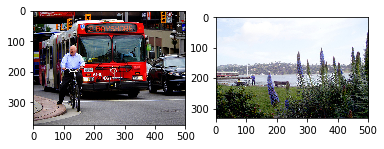

In [127]:

import matplotlib.pyplot as plt
#plt.imshow(images[1])
print(y)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(images[1])
axarr[1].imshow(images[-2])
plt.savefig('examples.pdf')


(array([ 3.,  0.,  0.,  1.,  0.,  0.,  4.,  0.,  0.,  2.]),
 array([ 0.65432099,  0.65506173,  0.65580247,  0.65654321,  0.65728395,
         0.65802469,  0.65876543,  0.65950617,  0.66024691,  0.66098765,
         0.6617284 ]),
 <a list of 10 Patch objects>)

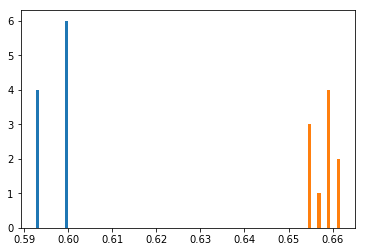

In [131]:
plt.hist([x[1] for x in acc])
plt.hist([x[0] for x in acc_baseline])

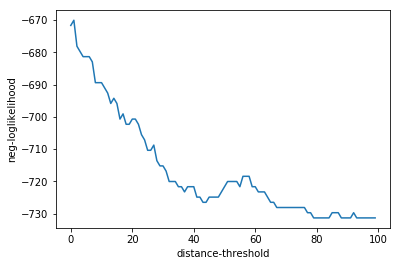

In [138]:
plt.plot(one_d[0:100])
plt.xlabel('distance-threshold')
plt.ylabel('neg-loglikelihood')
plt.savefig('dis.pdf')

In [145]:
print(np.mean([x[1] for x in acc]), np.mean([x[1] for x in acc_baseline]))
print(np.mean([x[1] for x in f1]), np.mean([x[1] for x in f1_baseline]))

0.597037037037 0.58
0.624236037935 0.584473954284
